https://developer.spotify.com/documentation/web-api/
https://developer.spotify.com/
https://developer.spotify.com/dashboard/login

**Objectives:**
- recommend the next song for an user base on his current playlist

**Assumptions:**
- tracks of a given playlist are the favorite songs of the user

**Methodology:**
1. Collaborative filtering
2. Initial sample for each user will take 70% of the tracks in the playlist (check if the sorting of the musics in the playlist has any information - date of inclusion, user sorting, etc) and then use the remaining 30% of the tracks as test.
3. **If we have time:** Hybrid model by adding *Content based filtering* for playlists with few tracks
    - Track features: genre, time, top_track, etc.
**Concerns:**
- cold start: playlists with few tracks
- rare tracks: treatment to be applied to the tracks with low frequency on the database
- only positive rating: we will have only tracks that the user liked, we do not have any data about tracks that they did not like.


**Python Libraries:**
- Sagemaker
- Elasticsearch
- PySpark

In [1]:
# Default libraries: pandas, numpy
# import beakerx
import cProfile
import collections
import datetime

import feather
import itertools
import math
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import urbangrammar_graphics as ugg

from IPython.display import Markdown as md
from collections import Counter
from clustergram import Clustergram
from datetime import datetime
from dotenv import load_dotenv
from itertools import groupby

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

pd.options.display.float_format = "{:.2f}".format
# plt.rcParams.update({'font.size': 18})

In [2]:
load_dotenv()
SPOTIPY_API = os.getenv('SPOTIPY_API')
SPOTIPY_API_KEY = os.getenv('SPOTIPY_API_KEY')
scope=''

# https://spotipy.readthedocs.io/en/latest/#
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_API, client_secret=SPOTIPY_API_KEY)

# help(sp)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
def single_list(my_list):
    single = []
    for e in my_list:
        single.extend(e)
    return single

def single_list_nested(my_list):
    single = []
    for e in my_list:
        for a in e:
            single.extend(a)
    return single

def sorted_list(xs):
    counts = collections.defaultdict(int)
    for x in xs:
        counts[x] += 1
    return sorted(counts.items(), reverse=True, key=lambda tup: tup[1])

In [4]:
data_path = os.getcwd() + '\\data\\external\\raw_data.pkl'
df = pd.read_pickle(data_path)
print(df.info())

# total = 0
# idx = 0
# while total < 10000:
# #     print(len(df.iloc[idx, 2]))
    
#     total = total + len(df.iloc[idx, 2])
#     idx = idx + 1
# #     len(df.iloc[0:n, :])
# print(idx)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      2450 non-null   object
 1   playlist_id  2450 non-null   object
 2   tracks_id    2450 non-null   object
 3   tracks       2450 non-null   object
 4   popularity   2450 non-null   object
 5   artists_id   2450 non-null   object
 6   artists      2450 non-null   object
 7   albums_id    2450 non-null   object
 8   albums       2450 non-null   object
dtypes: object(9)
memory usage: 172.4+ KB
None


In [5]:
def playlist_to_row(playlist, track_matrix):
    for col_track in playlist:
                if col_track is not None:
                    col = s_tracks_id.index(col_track)
                    track_matrix[row, col] += 1

In [6]:
def ranking(df,id_column):
    single_list_temp = single_list(df[id_column])
    data = {id_column: single_list_temp}
    aux_df = pd.DataFrame(data)
    
    name = id_column.replace('_id','_count')
    ranked_sorted = aux_df.groupby([id_column]).agg(
        temp_count=pd.NamedAgg(column=id_column, aggfunc="count")
    )
    ranked_sorted = ranked_sorted.rename(columns={'temp_count': name})
    ranked_sorted = ranked_sorted.sort_values(name,ascending=False)
    return ranked_sorted
# ranking(df_test,'tracks_id')
# print(tracks_rank)

def top(ranked,n):
    top_n = ranked.iloc[:n]
    
    return top_n
# tracks_rank = ranking(df_test,'tracks_id')
# top(tracks_rank,10)


In [7]:
# matrix track x track
idx = 100
df_test = df.iloc[0:idx, :]
# df_test = df

print(df_test.info())

track_rank = ranking(df_test,'tracks_id')
s_tracks_id = list(track_rank.index)

shape = [len(s_tracks_id), len(s_tracks_id)]
track_matrix = np.zeros(shape, dtype=int, order='C')

for i, row_track in enumerate(s_tracks_id):
    row = s_tracks_id.index(row_track)
    if i != row: print("i: " + str(i) + ": " + row_track), print()

    for playlist in df_test['tracks_id']:
        try:
            check = playlist.index(row_track)
        except ValueError:
            #             print(row)
            check = -1
        if check >= 0:
            for col_track in playlist:
                if col_track is not None:
                    col = s_tracks_id.index(col_track)
                    #                     print(col_track  + " - " + str(col))
                    #                     tr = df_test['tracks'][n][col]
                    #                     print("track: " + str(n) + ": " + col_track + " - col_match:" + str(col) + ": ") # + tr)
                    track_matrix[row, col] += 1
# print(track_matrix)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      100 non-null    object
 1   playlist_id  100 non-null    object
 2   tracks_id    100 non-null    object
 3   tracks       100 non-null    object
 4   popularity   100 non-null    object
 5   artists_id   100 non-null    object
 6   artists      100 non-null    object
 7   albums_id    100 non-null    object
 8   albums       100 non-null    object
dtypes: object(9)
memory usage: 7.2+ KB
None


In [8]:
track_matrix

array([[15, 11, 11, ...,  0,  0,  0],
       [11, 15,  9, ...,  0,  0,  0],
       [11,  9, 15, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  1,  0,  1],
       [ 0,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  1,  0,  1]])

In [9]:
# compare principal diagonal versus the counting of each track
# print(tracks_rank)
n_rows, n_cols = track_matrix.shape

# for track in tracks_rank:
#     print(track[1])
#     if track_matrix[i][i] != track_matrix[i][i]:
#             print("Difference: " + str(i) + ", " + str(j))

In [10]:
# Check if the matrix is symmetrical
n_rows, n_cols = track_matrix.shape
for i in range(0,n_rows):
    for j in range(i,n_cols):
        if track_matrix[i][j] != track_matrix[j][i]:
            print("Difference: " + str(i) + ", " + str(j))

In [11]:
# Check if the sum of rows matches the sum of the columns
column_sums = track_matrix.sum(axis=0)
row_sums = track_matrix.sum(axis=1)

print(column_sums)
print(row_sums)

if len(column_sums) != len(row_sums):
    print("error col * row")

for i in range(0,len(row_sums)):
     if row_sums[i] != column_sums[i]:
            print("Difference: " + str(i) + "," + str(j))

[1250 1190  990 ...   30   25   30]
[1250 1190  990 ...   30   25   30]


In [12]:
# Scale by row
# min_max = MinMaxScaler()
# tracks_rank['count_scaled'] = min_max.fit_transform(tracks_rank[["tracks_count"]])

track_normed = track_matrix / track_matrix.max(axis=0)
track_normed_by_row = track_matrix / track_matrix.max(axis=1)

delta = track_normed - track_normed_by_row
print(delta.sum())

0.0


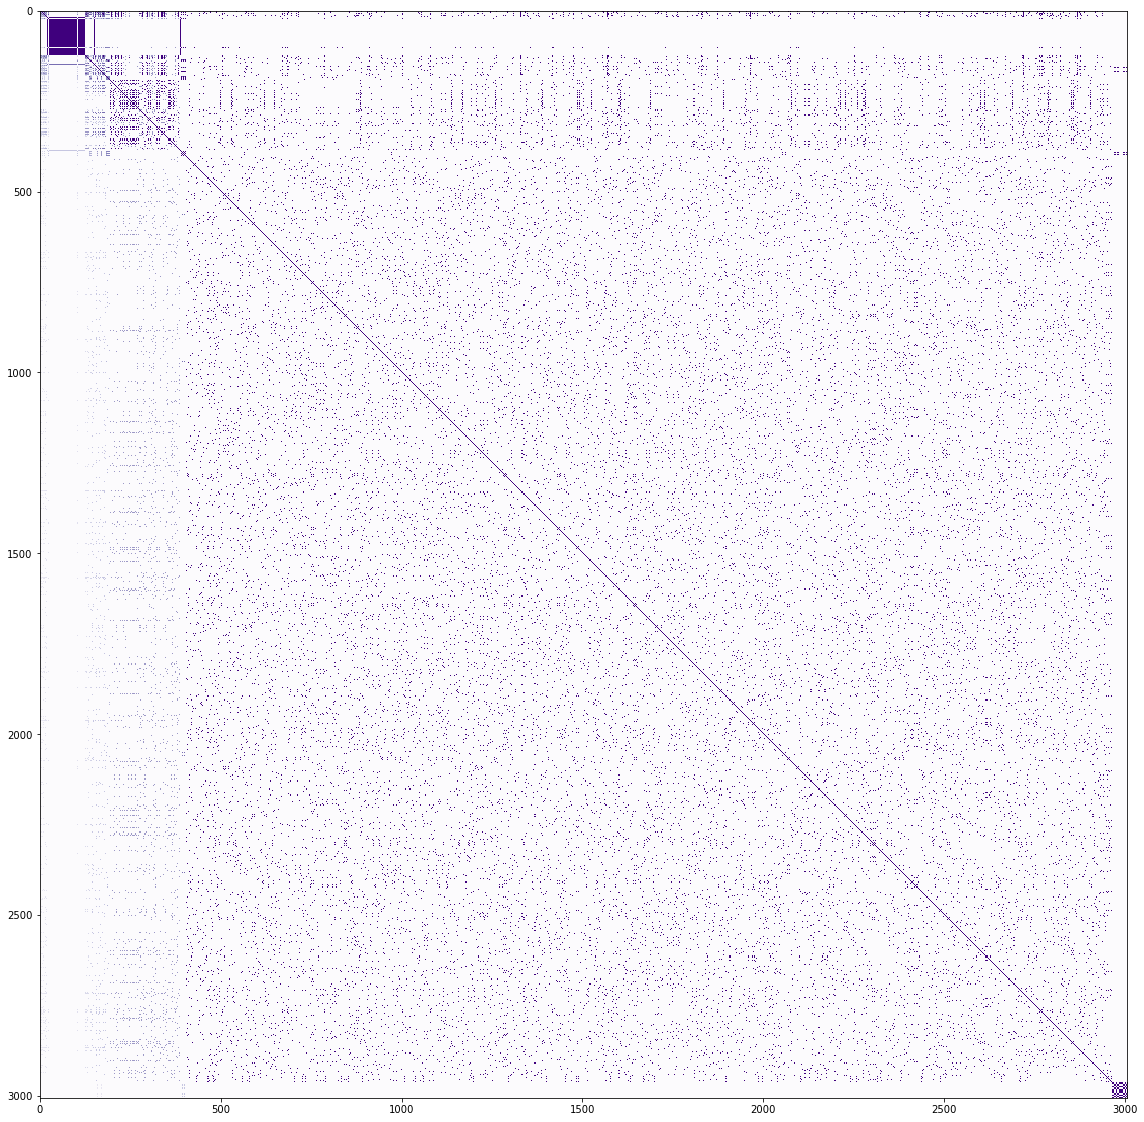

In [13]:
# graphical visualization
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(111)
# plt.imshow(track_matrix, interpolation='nearest', cmap=plt.cm.gist_heat)
plt.imshow(track_normed, interpolation='nearest', cmap=plt.cm.Purples)
ax.set_aspect('equal')
plt.show()

In [14]:
def get_playlist_detail(user_id, playlist_id):
    l_artists = []
    l_albums = []
    l_tracks = []
    l_popularity = []
    l_artists_id = []
    l_albums_id = []
    l_tracks_id = []
    
    playlist = sp.user_playlist(user_id, playlist_id)
    
    for item in playlist['tracks']['items']:
#         group = []
#         group_id = []
        for artist in item['track']['album']['artists']:
            group.append(artist['name'])
            group_id.append(artist['id'])
        l_artists.append(group)
        l_artists_id.append(group_id)
        l_albums.append(item['track']['album']['name'])
        l_tracks.append(item['track']['name'])
        l_popularity.append(item['track']['popularity'])
        
        l_albums_id.append(item['track']['album']['id'])
        l_tracks_id.append(item['track']['id'])
        
    playlist_details = zip(user_id, playlist_id, l_artists, l_albums, l_tracks, l_popularity, l_artists_id, l_albums_id, l_tracks_id)
    return playlist_details;

# user_id, playlist_id, l_artists, l_albums, l_tracks, l_popularity, l_artists_id, l_albums_id, l_tracks_id = get_playlist_detail('spotify', '37i9dQZF1DWXjlWxUbm84A')
# user_id, playlist_id, l_artists, l_albums, l_tracks, l_popularity, l_artists_id, l_albums_id, l_tracks_id

In [15]:
# temp = df_test[['tracks_id','tracks']]
# print(temp)

# for i, a in enumerate(temp['tracks_id']):
#     print(i)
#     print(a)

# for i in df_test:
#     print(i)

# print(temp['tracks'][1])
# df_test[['tracks','tracks_id','popularity']].iloc[1]

In [16]:
def dict_id_name(data, id_column, name_column):
    dict_id_name = dict()

    for i, item in enumerate(data[[id_column, name_column]][id_column]):
        dict_id_name = dict(
            zip(item, data[[id_column, name_column]][name_column][i]))
    return dict_id_name


# dict_id_name(df_test,'tracks_id','tracks')


def dict_tracks(data):
    dict_id_name = dict()

    for i, item in enumerate(data['tracks_id']):
#         print(i)
#         print(item)
#         print(
#             data[[
#                 'tracks', 'popularity', 'artists_id', 'artists', 'albums_id',
#                 'albums'
#             ]].iloc[i])
        dict_id_name = dict(
            zip(
                item, data[[
                    'tracks', 'popularity', 'artists_id', 'artists',
                    'albums_id', 'albums'
                ]].iloc[i]))


print(dict_tracks(df_test[:2]))

None


In [17]:
t_start = time.time()
data_path = os.getcwd() + '\\data\\external\\raw_1_uid_pid.pkl'
if os.path.exists(data_path):
    data_path_2 = os.getcwd() + '\\data\\external\\raw_2_playlists.pkl'
    if not(os.path.exists(data_path_2)):
        with open(data_path, 'rb') as f:
            uid_pid_raw = pickle.load(f)
else:
    n = 950 # max = 950
    p_limit = 50 # limit of playlists max = 50

    # list of all user ids (UID) and playlist ids (PID)
    uid_pid_raw = []
    
    for y in range(2018,2022,1):
        txt = 'year:' + str(y)
        for i in range(0,n,1):
            if i % 100 == 0: print(txt + ': ' + str(i) + '/' + str(n))
            uid_pid = sp.search(q=txt, type='playlist', limit=p_limit, offset=i,market='US')
            uid_pid_raw.append(uid_pid)
    # Save the data
    with open(data_path, 'wb') as f:
        pickle.dump(playlist_raw, f)


t_end = time.time()
np.abs(t_start - t_end)

2.132556438446045

In [18]:
t_start = time.time()
data_path = os.getcwd() + '\\data\\external\\raw_2_playlists.pkl'
if os.path.exists(data_path):
    print("Loading data...")
    data_path_2 = os.getcwd() + '\\data\\external\\split_1_playlists.pkl'
    if not(os.path.exists(data_path_2)):
        with open(data_path, 'rb') as f:
            playlist_raw = pickle.load(f)
else:
    print("Requesting playlists - Spotipy")
#     playlist_raw = []

#     for i, result in enumerate(uid_pid_raw):
#         print(i)
#         if i % 100 == 0: print(i)
#         for user in result['playlists']['items']:
#             pid = user['id']
#             uid = user['owner']['id']
#             try:
#                 playlist = sp.user_playlist(user['id'],user['owner']['id'])
#                 playlist_raw.append(playlist)
#             except:
#                 print(uid + " " + pid)
                   
   # Save the data
#     with open(data_path, 'wb') as f:
#         pickle.dump(playlist_raw, f)

t_end = time.time()
np.abs(t_start - t_end)

Requesting playlists - Spotipy


0.0009970664978027344

In [19]:
t_start = time.time()
data_path = os.getcwd() + '\\data\\external\\raw_data.pkl'
if os.path.exists(data_path):
    df = pd.read_pickle(data_path)
else:
#     print('ops')
    n = 50
    p_limit = 50 # limit of playlists max = 50

    user_id = []
    playlist_id = []
    artist = []
    album = []
    track = []
    popularity = []
    artist_id = []
    album_id = []
    track_id = []

    for i in uid_pid:
        if i-1 % 100 == 0: print(i)
        for user in result['playlists']['items']:
            pid = user['id']
            uid = user['owner']['id']
#                 user_id.append(uid)
#                 playlist_id.append(pid)
            p_user_id, p_playlist_id, p_artist, p_album, p_track, p_popularity, p_artists_id, p_albums_id, p_tracks_id = unzip(get_playlist_detail(uid,pid))

            user_id.append(p_user_id)
            playlist_id.append(p_playlist_id)
            artist.append(p_artist)
            album.append(p_album)
            track.append(p_track)
            popularity.append(p_popularity)
            artist_id.append(p_artist_id)
            album_id.append(p_album_id)
            track_id.append(p_track_id)
#             if i-1 % 100 == 0: print('tot:' + str(len(playlist_id)))

    # intialise data of lists.
    data = {
        'user_id': user_id,
        'playlist_id': playlist_id,
        'track_id': track_id,
        'track': track,
        'popularity': popularity,
        'artist_id': artist_id,
        'artist': artist,
        'album_id': albums_id,
        'album': album
    }

    # Create DataFrame
    df = pd.DataFrame(data)
    df.head()

    # Save the data
    df.to_pickle(data_path)

t_end = time.time()
np.abs(t_start - t_end)

0.7639555931091309

In [20]:
s_tracks_id = single_list(df['tracks_id'])
s_tracks = single_list(df['tracks'])
s_popularity = single_list(df['popularity'])

s_artists = single_list_nested(df['artists'])
s_artists_id = single_list_nested(df['artists_id'])

s_albums = single_list(df['albums'])
s_albums_id = single_list(df['albums_id'])

data = {
    'tracks_id': s_tracks_id,
    'tracks': s_tracks,
    'popularity': s_popularity
}
df_track = pd.DataFrame(data)
# print(df_track.head())

data = {
    'artists_id': s_artists_id,
    'artists': s_artists
}
df_artist = pd.DataFrame(data)
# print(df_artist.head())


data = {
    'albums_id': s_albums_id,
    'albums': s_albums
}
df_album = pd.DataFrame(data)
# print(df_album.head())

In [21]:
tracks_rank = df_track.groupby(['tracks_id','tracks']).agg(
    popularity=('popularity','max'),
    tracks_count=('tracks_id','count')
    )

min_max = MinMaxScaler()
tracks_rank['count_scaled'] = min_max.fit_transform(tracks_rank[["tracks_count"]])

tracks_rank["rank"] = tracks_rank['tracks_count'].rank(method='average',ascending=False)

tracks_rank = tracks_rank.sort_values('tracks_count',ascending=False)

tracks_rank

,,popularity,tracks_count,count_scaled,rank
tracks_id,tracks,,,,
2xLMifQCjDGFmkHkpNLD9h,SICKO MODE,83,236,1.00,1.00
2G7V7zsVDxg1yRsu7Ew9RJ,In My Feelings,76,213,0.90,2.00
45Egmo7icyopuzJN0oMEdk,Love Lies (with Normani),74,203,0.86,3.00
3ee8Jmje8o58CHK66QrVC2,SAD!,84,199,0.84,4.00
10Igtw8bSDyyFs7KIsKngZ,Freaky Friday (feat. Chris Brown),71,196,0.83,5.00
...,...,...,...,...,...
6K8qKeWo5MsFED7wCR6Kop,Sing,72,1,0.00,6479.50
6KBYk8OFtod7brGuZ3Y67q,Misery,60,1,0.00,6479.50
2iuZJX9X9P0GKaE93xcPjk,Sugar,80,1,0.00,6479.50


In [22]:
album_rank = df_album.groupby(['albums_id','albums']).agg(album_count=('albums_id','count'))

min_max = MinMaxScaler()
album_rank['count_scaled'] = min_max.fit_transform(album_rank[["album_count"]])

album_rank["rank"] = album_rank['album_count'].rank(method='average',ascending=False)

album_rank = album_rank.sort_values('album_count',ascending=False)

album_rank

,,album_count,count_scaled,rank
albums_id,albums,,,
1kS7q9KBO8X6xfGffRcYaH,A State Of Trance Year Mix 2018 (Mixed by Armin van Buuren),11800,1.00,1.00
7fAZC9BKYwEqZsCc488QHl,A State Of Trance Year Mix 2016 (Mixed by Armin van Buuren),1649,0.14,2.00
4HvKkLUMiYoQfqQ8wDGzJL,The United States of Russia,1620,0.14,3.00
66Rs4ct2c0Y6Ao9ICN7RhY,The Fresh Prince of Donair,810,0.07,4.00
4gTOSlnyuvjaN5D7S7NfdD,Ok,675,0.06,5.00
...,...,...,...,...
1yx0lKqG8Z1J3IOxx4gbzs,Nina,1,0.00,4953.50
1W9toxqtPfieKk6cft0f7R,Streets Of Gold,1,0.00,4953.50
1hwjIPHrnNBFuxWBWRHmge,'Di Na Muli,1,0.00,4953.50


In [23]:
df_artist.head
artist_rank = df_artist.groupby(['artists_id','artists']).agg(artist_count=('artists_id','count'))

min_max = MinMaxScaler()
artist_rank['count_scaled'] = min_max.fit_transform(artist_rank[["artist_count"]])

artist_rank["rank"] = artist_rank['artist_count'].rank(method='average',ascending=False)

artist_rank = artist_rank.sort_values('artist_count',ascending=False)

artist_rank

,,artist_count,count_scaled,rank
artists_id,artists,,,
0SfsnGyD8FpIN4U4WCkBZ5,Armin van Buuren,13691,1.00,1.00
0LyfQWJT6nXafLPZqxe9Of,Various Artists,9129,0.67,2.00
3Nrfpe0tUJi4K4DXYWgMUX,BTS,1884,0.14,3.00
39Bn2Hd2sBOQBFRR3jIzEV,Ben Rosenfeld,1620,0.12,4.00
4VMYDCV2IEDYJArk749S6m,Daddy Yankee,1331,0.10,5.00
...,...,...,...,...
3wbCeEPAW6po7J46netxMT,Up Dharma Down,1,0.00,3073.50
2U5mF0PZqGu6glnz55yY0y,John Roa,1,0.00,3073.50
0kkxsdcaWmWU2yWAqclDh4,Rixton,1,0.00,3073.50


In [24]:
# for key, item in df_test.items():
#     print(key)
#     if key == 'tracks_id':
#         print(item)

In [25]:
# # Define count_entries()
# def count_entries(csv_file,c_size,colname):
#     """Return a dictionary with counts of
#     occurrences as value for each key."""
    
#     # Initialize an empty dictionary: counts_dict
#     counts_dict = {}

#     # Iterate over the file chunk by chunk
#     for chunk in pd.read_csv(csv_file,chunksize=c_size):

#         # Iterate over the column in DataFrame
#         for entry in chunk[colname]:
#             if entry in counts_dict.keys():
#                 counts_dict[entry] += 1
#             else:
#                 counts_dict[entry] = 1

#     # Return counts_dict
#     return counts_dict

# # Call count_entries(): result_counts
# result_counts = count_entries('tweets.csv',10,'lang')

# # Print result_counts
# print(result_counts)
